In [18]:
# Loading the packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
# Get Bitcoin data
def get_bitcoin_price():
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "365",  # Change this to the number of days you want
        "interval": "daily"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        return df
    else:
        print("Error fetching data:", response.status_code)
        return None

# Example usage
if __name__ == "__main__":
    btc_data = get_bitcoin_price()
    if btc_data is not None:
        print(btc_data.head())

print(btc_data)

   timestamp         price
0 2024-07-06  56739.862851
1 2024-07-07  58230.484154
2 2024-07-08  55880.375378
3 2024-07-09  56665.140734
4 2024-07-10  57988.303512
              timestamp          price
0   2024-07-06 00:00:00   56739.862851
1   2024-07-07 00:00:00   58230.484154
2   2024-07-08 00:00:00   55880.375378
3   2024-07-09 00:00:00   56665.140734
4   2024-07-10 00:00:00   57988.303512
..                  ...            ...
361 2025-07-02 00:00:00  105613.399742
362 2025-07-03 00:00:00  108824.444232
363 2025-07-04 00:00:00  109602.204839
364 2025-07-05 00:00:00  108040.891940
365 2025-07-05 09:31:51  107935.084109

[366 rows x 2 columns]


In [3]:

# Get Ethereum data
def get_ethereum_price():
    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "365",  # Change this to the number of days you want
        "interval": "daily"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        return df
    else:
        print("Error fetching data:", response.status_code)
        return None

# Example usage
if __name__ == "__main__":
    eth_data = get_ethereum_price()
    if eth_data is not None:
        print(eth_data.head())

print(eth_data)

   timestamp        price
0 2024-07-06  2984.398102
1 2024-07-07  3066.247438
2 2024-07-08  2928.601231
3 2024-07-09  3016.083354
4 2024-07-10  3064.092361
              timestamp        price
0   2024-07-06 00:00:00  2984.398102
1   2024-07-07 00:00:00  3066.247438
2   2024-07-08 00:00:00  2928.601231
3   2024-07-09 00:00:00  3016.083354
4   2024-07-10 00:00:00  3064.092361
..                  ...          ...
361 2025-07-02 00:00:00  2405.104559
362 2025-07-03 00:00:00  2574.067718
363 2025-07-04 00:00:00  2590.132232
364 2025-07-05 00:00:00  2509.236346
365 2025-07-05 09:32:03  2511.935251

[366 rows x 2 columns]


In [4]:

# Get Ethereum data
def get_ripple_price():
    url = "https://api.coingecko.com/api/v3/coins/ripple/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "365",  # Change this to the number of days you want
        "interval": "daily"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        return df
    else:
        print("Error fetching data:", response.status_code)
        return None

# Example usage
if __name__ == "__main__":
    xrp_data = get_ripple_price()
    if xrp_data is not None:
        print(xrp_data.head())

print(xrp_data)

   timestamp     price
0 2024-07-06  0.425391
1 2024-07-07  0.448871
2 2024-07-08  0.419179
3 2024-07-09  0.431465
4 2024-07-10  0.435768
              timestamp     price
0   2024-07-06 00:00:00  0.425391
1   2024-07-07 00:00:00  0.448871
2   2024-07-08 00:00:00  0.419179
3   2024-07-09 00:00:00  0.431465
4   2024-07-10 00:00:00  0.435768
..                  ...       ...
361 2025-07-02 00:00:00  2.171454
362 2025-07-03 00:00:00  2.234340
363 2025-07-04 00:00:00  2.256599
364 2025-07-05 00:00:00  2.220661
365 2025-07-05 09:32:08  2.213917

[366 rows x 2 columns]


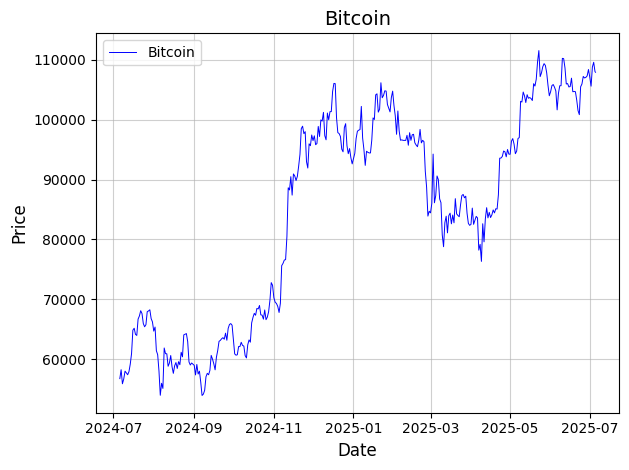

In [5]:
# Bitcoin
plt.plot(btc_data['timestamp'],
         btc_data['price'],
         label='Bitcoin',
         color='blue',
         linewidth=0.7)


plt.title('Bitcoin', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

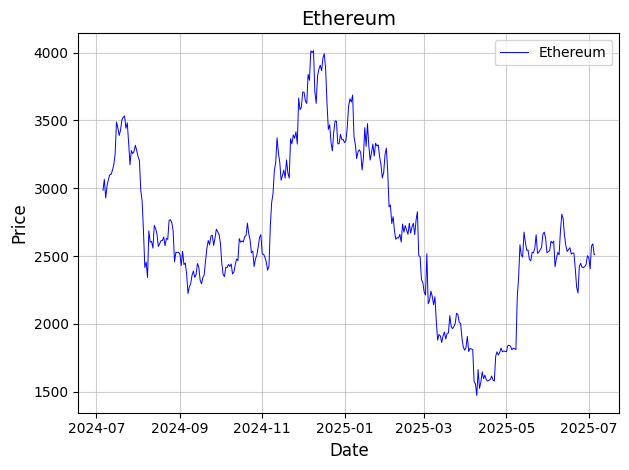

In [6]:
# Ethereum
plt.plot(eth_data['timestamp'],
         eth_data['price'],
         label='Ethereum',
         color='blue',
         linewidth=0.7)


plt.title('Ethereum', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

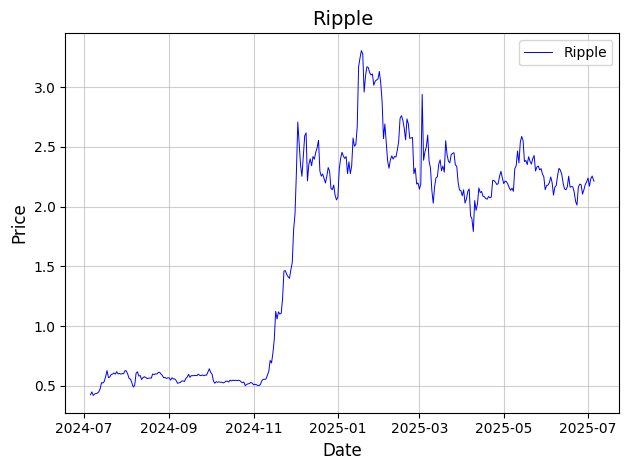

In [7]:
# Ripple
plt.plot(xrp_data['timestamp'],
         xrp_data['price'],
         label='Ripple',
         color='blue',
         linewidth=0.7)


plt.title('Ripple', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Define a function to apply transformations on each group
def add_features(group):

    # Create moving averages (2-day, 4-day)
    group['MA_2'] = group['price'].rolling(window=2).mean()
    group['MA_4'] = group['price'].rolling(window=4).mean()

    # Rolling standard deviation (volatility) over 3 days
    group['Volatility_3'] = group['price'].rolling(window=3).std()

    # Daily returns as a feature
    group['Daily_Return'] = group['price'].pct_change()

    # Relative Strength Index (RSI)
    def RSI(series, period=3):
        delta = series.diff(1)
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    group['RSI_3'] = RSI(group['price'])

    # MACD (Moving Average Convergence Divergence)
    short_ema = group['price'].ewm(span=12, adjust=False).mean()
    long_ema = group['price'].ewm(span=26, adjust=False).mean()
    group['MACD'] = short_ema - long_ema
    group['Signal_Line'] = group['MACD'].ewm(span=9, adjust=False).mean()

    return group

In [9]:
# Add features to each dataset
add_features(eth_data)
add_features(btc_data)
add_features(xrp_data)

,timestamp,price,MA_2,MA_4,Volatility_3,Daily_Return,RSI_3,MACD,Signal_Line
0,2024-07-06 00:00:00,0.425391,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2024-07-07 00:00:00,0.448871,0.437131,NaN,NaN,0.055194,NaN,0.001873,0.000375
2,2024-07-08 00:00:00,0.419179,0.434025,NaN,0.015660,-0.066148,44.157994,0.000951,0.000490
3,2024-07-09 00:00:00,0.431465,0.425322,0.431226,0.014919,0.029310,54.639287,0.001197,0.000631
4,2024-07-10 00:00:00,0.435768,0.433617,0.433821,0.008609,0.009974,35.844763,0.001720,0.000849
...,...,...,...,...,...,...,...,...,...
361,2025-07-02 00:00:00,2.171454,2.205620,2.201265,0.034196,-0.030509,44.161601,-0.010324,-0.022208
362,2025-07-03 00:00:00,2.234340,2.202897,2.213414,0.037978,0.028960,58.059246,-0.004663,-0.018699
363,2025-07-04 00:00:00,2.256599,2.245469,2.225545,0.044158,0.009962,55.476883,0.001601,-0.014639
364,2025-07-05 00:00:00,2.220661,2.238630,2.220763,0.018139,-0.015926,70.319505,0.003624,-0.010987


In [10]:
# Create target variable
btc_data['target'] = (btc_data['price'] > btc_data['price'].shift(1)).astype(int)
eth_data['target'] = (eth_data['price'] > eth_data['price'].shift(1)).astype(int)
xrp_data['target'] = (xrp_data['price'] > xrp_data['price'].shift(1)).astype(int)

In [11]:
# Drop rows with NaN values
btc_data.dropna(inplace=True)
eth_data.dropna(inplace=True)
xrp_data.dropna(inplace=True)

In [12]:
train_df = pd.concat([btc_data[btc_data['timestamp'] < '2025-02-15'], eth_data[eth_data['timestamp'] < '2025-02-15'], xrp_data[xrp_data['timestamp'] < '2025-02-15']], ignore_index=True)
test_df = pd.concat([btc_data[btc_data['timestamp'] >= '2025-02-15'], eth_data[eth_data['timestamp'] >= '2025-02-15'], xrp_data[xrp_data['timestamp'] >= '2025-02-15']], ignore_index=True)

print(train_df.shape)
print(test_df.shape)
print(train_df.shape[0]+test_df.shape[0])

(663, 10)
(426, 10)
1089


In [13]:
print('Train df:')
print(train_df.value_counts(train_df['target']))
print('Share of increasing subjects: ',(train_df.value_counts(train_df['target'])[1])/(train_df.value_counts(train_df['target'])[1]+train_df.value_counts(train_df['target'])[0]))
print('')
print('Test df:')
print(test_df.value_counts(test_df['target']))
print('Share of increasing subjects: ',(test_df.value_counts(test_df['target'])[1])/(test_df.value_counts(test_df['target'])[1]+test_df.value_counts(test_df['target'])[0]))

Train df:
target
1    352
0    311
Name: count, dtype: int64
Share of increasing subjects:  0.530920060331825

Test df:
target
0    214
1    212
Name: count, dtype: int64
Share of increasing subjects:  0.49765258215962443


In [14]:
# Select relevant features and target for modeling
X_train = train_df[['MA_2', 'MA_4', 'Volatility_3',
            'Daily_Return', 'RSI_3', 'MACD', 'Signal_Line']]

y_train = train_df[['target']]

X_test = test_df[['MA_2', 'MA_4', 'Volatility_3',
            'Daily_Return', 'RSI_3', 'MACD', 'Signal_Line']]

y_test = test_df[['target']]

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(663, 7)
(426, 7)
(663, 1)
(426, 1)


In [19]:
# Model parameters
logistic_param_grid = {'C': np.logspace(-4, 4, 20), 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
dt_param_grid = {'max_depth': np.arange(1, 100), 'min_samples_split': np.arange(10, 100), 'min_samples_leaf': np.arange(5, 100), 'criterion': ['gini', 'entropy']}
rf_param_grid = {'n_estimators': np.arange(100, 1001, 100), 'max_depth': np.arange(1, 100), 'min_samples_split': np.arange(10, 100), 'min_samples_leaf': np.arange(5, 100), 'max_features': ['sqrt', 'log2']}
xgb_param_grid = {'n_estimators': np.arange(100, 1001, 100), 'max_depth': np.arange(1, 11), 'learning_rate': np.logspace(-4, -1, 10), 'subsample': [0.6, 0.8, 1.0]}
mlp_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'learning_rate': ['constant', 'adaptive']}

In [21]:
# Initialize dictionaries to store results
accuracy_results = {'Model': [], 'Train Accuracy': [], 'Test Accuracy': []}
precision_results = {'Model': [], 'Train Precision': [], 'Test Precision': []}

# Helper function for model tuning, evaluation, and result storage
def tune_evaluate_and_store_results(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    # Perform RandomizedSearchCV
    search = RandomizedSearchCV(model, param_grid, scoring='precision', cv=5, n_iter=10, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')

    # Store results
    accuracy_results['Model'].append(model_name)
    accuracy_results['Train Accuracy'].append(train_accuracy)
    accuracy_results['Test Accuracy'].append(test_accuracy)
    precision_results['Model'].append(model_name)
    precision_results['Train Precision'].append(train_precision)
    precision_results['Test Precision'].append(test_precision)

    print(f'Optimal parameters for {model_name}: {search.best_params_}')

    # Return the best model
    return best_model

In [23]:
# Train, evaluate and store results for each model
m_logreg = tune_evaluate_and_store_results(LogisticRegression(max_iter=1000), logistic_param_grid, "Logistic Regression", X_train, y_train, X_test, y_test)
m_dtree = tune_evaluate_and_store_results(DecisionTreeClassifier(), dt_param_grid, "Decision Tree", X_train, y_train, X_test, y_test)
m_rf = tune_evaluate_and_store_results(RandomForestClassifier(), rf_param_grid, "Random Forest", X_train, y_train, X_test, y_test)
m_xgboost = tune_evaluate_and_store_results(XGBClassifier(), xgb_param_grid, "XGBoost", X_train, y_train, X_test, y_test)
m_mlp = tune_evaluate_and_store_results(MLPClassifier(max_iter=500), mlp_param_grid, "Feed Forward NN", X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(10000.0)}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for Decision Tree: {'min_samples_split': np.int64(56), 'min_samples_leaf': np.int64(32), 'max_depth': np.int64(15), 'criterion': 'gini'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Optimal parameters for Random Forest: {'n_estimators': np.int64(200), 'min_samples_split': np.int64(76), 'min_samples_leaf': np.int64(5), 'max_features': 'log2', 'max_depth': np.int64(8)}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal parameters for AdaBoost: {'n_estimators': np.int64(200), 'learning_rate': np.float64(0.021544346900318832)}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for XGBoost: {'subsample': 0.6, 'n_estimators': np.int64(500), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.046415888336127774)}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Optimal parameters for KNN: {'weights': 'uniform', 'p': 1, 'n_neighbors': np.int64(24)}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal parameters for Feed Forward NN: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'activation': 'tanh'}


In [24]:
# Convert dictionaries to DataFrames for display
accuracy_df = pd.DataFrame(accuracy_results)
precision_df = pd.DataFrame(precision_results)

In [25]:
# Display the results
print("Accuracy Results Table")
print(accuracy_df)

Accuracy Results Table
                  Model  Train Accuracy  Test Accuracy
0   Logistic Regression        0.894419       0.852113
1         Decision Tree        1.000000       1.000000
2         Random Forest        1.000000       1.000000
3              AdaBoost        1.000000       1.000000
4               XGBoost        0.998492       1.000000
5   Logistic Regression        0.987934       0.988263
6         Decision Tree        1.000000       1.000000
7         Random Forest        1.000000       1.000000
8              AdaBoost        1.000000       1.000000
9               XGBoost        1.000000       1.000000
10                  KNN        0.641026       0.542254
11      Feed Forward NN        0.574661       0.563380


In [26]:
# Display the percision results
print("\nPrecision Results Table")
print(precision_df)


Precision Results Table
                  Model  Train Precision  Test Precision
0   Logistic Regression         0.894583        0.852124
1         Decision Tree         1.000000        1.000000
2         Random Forest         1.000000        1.000000
3              AdaBoost         1.000000        1.000000
4               XGBoost         0.998496        1.000000
5   Logistic Regression         0.987956        0.988359
6         Decision Tree         1.000000        1.000000
7         Random Forest         1.000000        1.000000
8              AdaBoost         1.000000        1.000000
9               XGBoost         1.000000        1.000000
10                  KNN         0.649788        0.542238
11      Feed Forward NN         0.610441        0.613418
